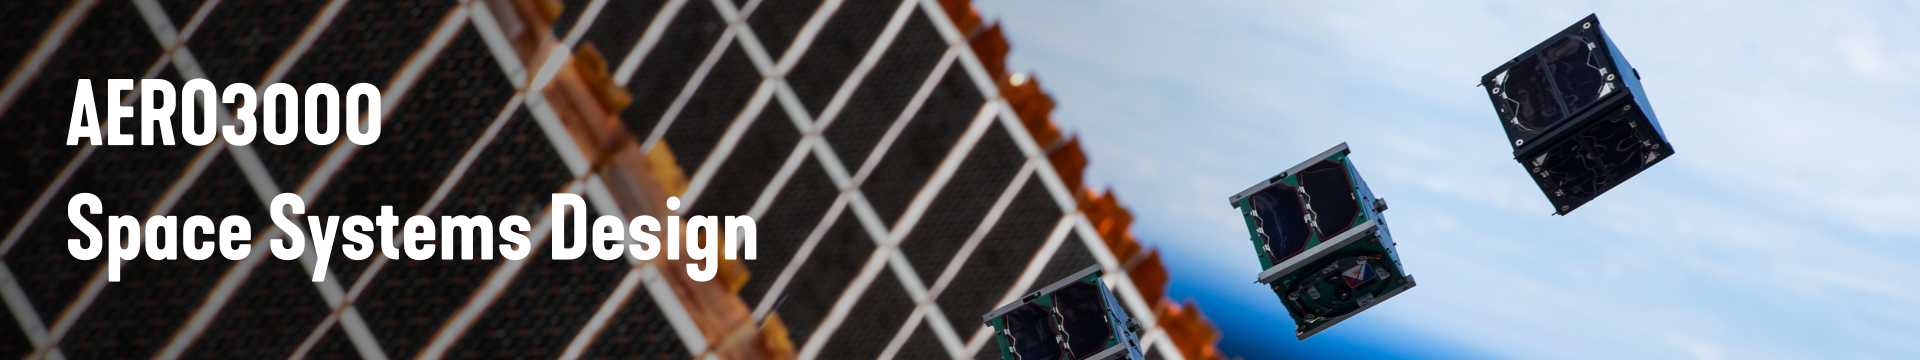

<table width="100%">
  <tr>
    <td width="33.3%" style="text-align:center;"><b>Faculty of Science and Engineering</b></th>
    <td width="33.3%" style="text-align:center;"><b>Space Science and Technology Centre</b></th>
    <td width="33.3%" style="text-align:center;"><b>CRICOS Provider Code 00301J</b></th>
  </tr>
<//div>
</html>

<p style="margin-left:40px;margin-right:40px;margin-top:20px;margin-bottom:20px;padding:20px;text-align:center;background-color:var(--jp-layout-color2, LightGray);font-weight:normal">Run the code cells below by pressing Shift+Enter on the keyboard to run each cell and advance to the next cell.</p>

In [5]:
#load libraries for JupyterLite
#only required one time ever for JupyterLab running locally or on a hosted JupyterHub instance
%pip install ipywidgets==8.1.1 plotly==5.21.0

In [6]:
import numpy as np #import array manipulation and maths library numpy under the alias np
import plotly.graph_objects as go #import our plotting library under the alias go
import ipywidgets as widgets #import our interactive widgets library under the alias widgets
from ipywidgets import interact,FloatSlider #for interactive sliders
from scipy.spatial.transform import Rotation as R #import SciPy rotation library under the alias R for Euler angle rotations

In [3]:
from astropy import units as u #import the astropy units package so we can use real world units conveniently

class Earth:
    """Earth class with useful atributes, used as poliastro is not available in JupyterLite"""
    name = "Earth"
    #radius
    #source:
    #Archinal, B.A. et al. "Report of the IAU working group on cartographic coordinates and rotational elements: 2015"
    #Celestial Mechanics and Dynamical Astronomy 109(2011): 101-135.
    #DOI: https://doi.org/10.1007/s10569-010-9320-4
    R =  6371.0084*u.km
    
    #gravitational parameter GM
    #source:
    #Luzum, Brian et al. “The IAU 2009 System of Astronomical Constants: The Report of the IAU Working Group on Numerical Standards for Fundamental Astronomy."
    #Celestial Mechanics and Dynamical Astronomy 110.4 (2011): 293–304.
    #DOI: https://doi.org/10.1007/s10569-011-9352-4
    k = 3.986004418e14*u.m**3/u.s**2
    
    #CSS colour name for plotting
    color = "lightskyblue"
    
    #atmosphere properties for plotting
    has_atmosphere = True
    #atmosphere "height" and CSS colour for visualisation
    atmosphere_height = 100*u.km
    atmosphere_color = "lightblue"
    atmosphere_opacity = 0.2

class Moon:
    """Moon class with useful atributes, used as poliastro is not available in JupyterLite"""
    name = "The Moon (Luna)"
    #radius
    #source:
    #Archinal, B.A. et al. "Report of the IAU working group on cartographic coordinates and rotational elements: 2015"
    #Celestial Mechanics and Dynamical Astronomy 109(2011): 101-135.
    #DOI: https://doi.org/10.1007/s10569-010-9320-4
    R = 1737.1*u.km #mean radius
    
    #gravitational parameter GM
    #source:
    #Lemoine, Frank G. et al. “High-Degree Gravity Models from GRAIL Primary Mission Data.”
    #Journal of Geophysical Research: Planets 118.8 (2013): 1676–1698.
    #DOI: https://doi.org/10.1002/jgre.20118
    k = 4.90279981e12*u.m**3/u.s**2
    
    #CSS colour name for plotting
    color = "lightgrey"
    
    #atmosphere properties for plotting
    has_atmosphere = False

In [4]:
#Primary body (that the spacecraft is orbiting)
body=Earth
#Initial orbital parameters for the spacecraft
sma_initial = (body.R+400*u.km).to(u.km).value
ecc_initial = 0
inc_initial = 0
raan_initial = 0
argp_initial = 0
nu_initial = 0

#size of cone representing spacecraft position and direction
sc_cone_scale = body.R.to(u.km).value/2

#resolution of orbit and body in plots
orbit_res = 100 #number of points used to plot ellipse
body_res = 70 #numbe or points to use in meshgrid creation

#size of 3d viewbox
box_scale = 10 #viewbox cube sidelengt in body radii

#height of 3d plot figure
figure_height = 800


def sphere3d(x_0, y_0, z_0, r, res):
    """Sphere surface creation function for use with Plotly go.Surface"""
    phi, theta = np.mgrid[0:np.pi:res*1j, 0:2*np.pi:res*1j] # create a meshgrid with 100 values for phi and 100 values for theta
    xs = x_0+r*np.sin(theta)*np.cos(phi)
    ys = y_0+r*np.sin(theta)*np.sin(phi)
    zs = z_0+r*np.cos(theta)
    
    return xs, ys, zs

def ellipse3d(sma, ecc, inc, raan, argp, res):
    """Ellipse line creation function for use with Plotly go.Scatter3d"""
    theta = np.linspace(0, 2*np.pi, res)
    
    #create ellipse points on a 2d plane
    ellipse_xs = sma*np.cos(theta)-sma*ecc
    ellipse_ys = sma*np.sqrt(1-ecc**2)*np.sin(theta)
    ellipse_zs = 0*theta
    
    #prepare datapoints for rotation matrix multiplication
    #source: https://community.plotly.com/t/controlling-animation-speed-using-graph-objects-in-python/41038/21
    m = ellipse_xs.shape
    xyz = np.vstack((ellipse_xs.flatten(),ellipse_ys.flatten(),ellipse_zs.flatten()))
    
    r = R.from_euler("zxz", [argp, inc, raan]).as_matrix() #create rotation matrix for raan, inc and argp rotations
    
    xyz_rotated = r @ xyz #apply rotation via matrix multiplication
    xs, ys, zs = xyz_rotated[0].reshape(m), xyz_rotated[1].reshape(m), xyz_rotated[2].reshape(m)
    
    return xs, ys, zs

def spacecraftCone(sma, ecc, inc, raan, argp, nu, sc_cone_scale):
    """Function to generate spacecraft position and direction coordinates for use with Plotly go.Cone"""
    step = 0.001 #step in nu for numerical differentiation
    nu0_nu1 = np.asarray([nu, nu+step, nu+2*step]) #calculate nu0 and nu1
    E = np.arctan(np.tan(nu0_nu1/2)/np.sqrt((1+ecc)/(1-ecc)))*2 #calculate eccentric anomaly for true anomaly nu0 and nu1
    
    #calculate spacecraft position on a 2d plane
    ellipse_xs = sma*np.cos(E)-sma*ecc
    ellipse_ys = sma*np.sqrt(1-ecc**2)*np.sin(E)
    ellipse_zs = 0*E
    
    #prepare datapoints for rotation matrix multiplication
    #source: https://community.plotly.com/t/controlling-animation-speed-using-graph-objects-in-python/41038/21
    m = ellipse_xs.shape
    ellipse_xyzs = np.vstack((ellipse_xs, ellipse_ys, ellipse_zs))
    
    r = R.from_euler("zxz", [argp, inc, raan]).as_matrix() #create rotation matrix for raan, inc and argp rotations
    
    xyzs = r @ ellipse_xyzs #apply rotation via matrix multiplication

    xs, ys, zs = xyzs[0].reshape(m), xyzs[1].reshape(m), xyzs[2].reshape(m)
    
    #calculate directions
    uvws = np.diff(xyzs)
    #scale first direction
    scaled_uvws_0 = sc_cone_scale*uvws.transpose()[0]/np.linalg.norm(uvws.transpose()[0])
    
    return [xs[0]], [ys[0]], [zs[0]], [scaled_uvws_0[0]], [scaled_uvws_0[1]], [scaled_uvws_0[2]]

#create a scatter plot from the x and y arrays
fig = go.FigureWidget()

fig.layout.template = "plotly_dark" #change plotly theme to dark mode

#update figure layout as needed
fig.update_layout(title_text="3D Orbit Plot", #set figure title
    #set height & activate width autosize
    height=figure_height,
    autosize=True,
    showlegend=False,
    scene=dict(
        #specify the aspect ratio as 1:1:1 to avoid squished objects after we set set the bounds
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=1),
        #set the view box size
        xaxis=dict(nticks=8, range=[-box_scale/2*body.R.to(u.km).value,box_scale/2*body.R.to(u.km).value],),
        yaxis=dict(nticks=8, range=[-box_scale/2*body.R.to(u.km).value,box_scale/2*body.R.to(u.km).value],),
        zaxis=dict(nticks=8, range=[-box_scale/2*body.R.to(u.km).value,box_scale/2*body.R.to(u.km).value],),
        #set axes titles
        xaxis_title="X Axis (km)",
        yaxis_title="Y Axis (km)",
        zaxis_title="Z Axis (km)"),
    #define the view angle
    # scene_camera_eye=dict(x=0.5*np.pi, y=0.5*np.pi, z=0.5*np.pi)
    )

#add the orbit ellipse to the graph
orbit_xs, orbit_ys, orbit_zs = ellipse3d(sma_initial, ecc_initial, inc_initial, raan_initial, argp_initial, orbit_res) #create orbit ellipse
fig.add_trace(go.Scatter3d(x=orbit_xs, y=orbit_ys, z = orbit_zs, mode="lines", marker_color="red", name="Orbit")) #add ellipse to graph

#add a cone for the spacecraft
sc_xs, sc_ys, sc_zs, sc_us, sc_vs, sc_ws = spacecraftCone(sma_initial, ecc_initial, inc_initial, raan_initial, argp_initial, nu_initial, sc_cone_scale)
fig.add_trace(go.Cone(x=sc_xs, y=sc_ys, z=sc_zs, u=sc_us, v=sc_us, w=sc_ws, name="Spacecraft", colorscale=[[0,"red"], [1, "red"]], opacity=0.5, showscale=False))

#add the body to the graph
body_xs, body_ys, body_zs = sphere3d(0, 0, 0, body.R.to(u.km).value, body_res) #create the body sphere surface
fig.add_trace(go.Surface(x=body_xs, y=body_ys, z=body_zs, name=body.name, colorscale=[[0,body.color], [1, body.color]], showscale=False)) #add the body to the graph

if(body.has_atmosphere):
    #add the atmosphere to the graph
    atmosphere_xs, atmosphere_ys, atmosphere_zs = sphere3d(0, 0, 0, body.R.to(u.km).value+body.atmosphere_height.to(u.km).value, body_res) #create the body sphere surface
    fig.add_trace(go.Surface(x=atmosphere_xs, y=atmosphere_ys, z=atmosphere_zs, name=body.name+"Atmosphere", colorscale=[[0,body.atmosphere_color], [1, body.atmosphere_color]], opacity=body.atmosphere_opacity, showscale=False)) #add the body to the graph

#add the Vernal Equinox reference to the plot
fig.add_trace(go.Scatter3d(x=[0, 2*body.R.to(u.km).value], y=[0,0], z=[0,0], mode="lines", marker_color="red", name="Vernal Equinox")) #add line to graph
fig.add_trace(go.Scatter3d(x=[2.15*body.R.to(u.km).value], y=[0,0], z=[0,0], mode="text", text="♈︎", textposition="middle center")) #add text to graph
#add the North reference to the plot
fig.add_trace(go.Scatter3d(x=[0,0], y=[0,0], z=[0, 2*body.R.to(u.km).value], mode="lines", marker_color="blue", name="North")) #add line to graph
fig.add_trace(go.Scatter3d(x=[0,0], y=[0,0], z=[2.15*body.R.to(u.km).value], mode="text", text="N", textposition="middle center")) #add text to graph
#add the +Y reference to the plot
fig.add_trace(go.Scatter3d(x=[0,0], y=[0, 2*body.R.to(u.km).value], z=[0,0], mode="lines", marker_color="green", name="+Y Axis")) #add line to graph
fig.add_trace(go.Scatter3d(x=[0,0], y=[2.15*body.R.to(u.km).value], z=[0,0], mode="text", text="+Y", textposition="middle center")) #add text to graph



#update function for graph
def update(sma_km, ecc, inc_deg, raan_deg, argp_deg, nu_deg):
    #convert sma into km
    sma = sma_km
    #convert parameters in degrees into radians
    inc = np.deg2rad(inc_deg)
    raan = np.deg2rad(raan_deg)
    argp = np.deg2rad(argp_deg)
    nu = np.deg2rad(nu_deg)
    #update 3d plot
    with fig.batch_update():
        #orbit
        orbit_xs, orbit_ys, orbit_zs = ellipse3d(sma, ecc, inc, raan, argp, orbit_res)
        fig.data[0].x = orbit_xs
        fig.data[0].y = orbit_ys
        fig.data[0].z = orbit_zs
        #spacecraft cone
        sc_x, sc_y, sc_z, sc_u, sc_v, sc_w = spacecraftCone(sma, ecc, inc, raan, argp, nu, sc_cone_scale)
        fig.data[1].x = sc_x
        fig.data[1].y = sc_y
        fig.data[1].z = sc_z
        fig.data[1].u = sc_u
        fig.data[1].v = sc_v
        fig.data[1].w = sc_w
        # fig.data[0].name = "Orbit: a = {}, e = {}, i = {}, raan = {}, argp = {}".format(sma, ecc, inc, raan, argp)

layout = widgets.Layout(width="99%") #make the widgets wider so the slider bars are bigger

#create the slider widgets and link up with the callback function that updates the graph        
interact(update,
    sma_km=FloatSlider(
        min=1000,
        max=60000,
        step=10,
        readout_format=".0f",
        value=sma_initial,
        description="Semi-Major Axis, a (km)",
        style={"description_width" : "initial"},
        continuous_update = True,
        layout = layout),
    ecc=FloatSlider(
        min=0,
        max=1,
        step=0.01,
        readout_format=".2f",
        value=ecc_initial,
        description="Eccentricity, e",
        style={"description_width" : "initial"},
        continuous_update = True,
        layout = layout),
    inc_deg=FloatSlider(
        min=0,
        max=180,
        step=0.5,
        readout_format=".1f",
        value=inc_initial,
        description="Inclination, i (deg)",
        style={"description_width" : "initial"},
        continuous_update = True,
        layout = layout),
    raan_deg=FloatSlider(
        min=0,
        max=360,
        step=0.5,
        readout_format=".1f",
        value=raan_initial,
        description="Right Ascension of the Ascending Node, Ω (deg)",
        style={"description_width" : "initial"},
        continuous_update = True,
        layout = layout),
    argp_deg=FloatSlider(
        min=0,
        max=360,
        step=0.5,
        readout_format=".1f",
        value=argp_initial,
        description="Argument of Periapsis, ω (deg)",
        style={"description_width" : "initial"},
        continuous_update = True,
        layout = layout),
     nu_deg=FloatSlider(
        min=0,
        max=360,
        step=0.5,
        readout_format=".1f",
        value=argp_initial,
        description="True Anomaly, ν (deg)",
        style={"description_width" : "initial"},
        continuous_update = True,
        layout = layout)
);

fig #diplay the interactive plot widget

interactive(children=(FloatSlider(value=6771.0084, description='Semi-Major Axis, a (km)', layout=Layout(width=…

FigureWidget({
    'data': [{'marker': {'color': 'red'},
              'mode': 'lines',
              'name': 'Orbit',
              'type': 'scatter3d',
              'uid': '6274e366-ef6a-4124-8ee7-c3f6f4e72dce',
              'x': array([ 6771.0084    ,  6757.37616948,  6716.5343701 ,  6648.64745737,
                           6553.98878792,  6432.93951882,  6285.98707274,  6113.72317532,
                           5916.84147247,  5696.13473733,  5452.49167801,  5186.89335913,
                           4900.40925138,  4594.19292513,  4269.47740547,  3927.57020718,
                           3569.84806988,  3197.75141436,  2812.77854252,  2416.47960424,
                           2010.45035548,  1596.32573271,  1175.77326963,   750.48638257,
                            322.17755173,  -107.4285744 ,  -536.60212358,  -963.61496539,
                          -1386.74766985, -1804.29643088, -2214.57992699, -2615.94609137,
                          -3006.77876411, -3385.5042    , -3750.5